In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
ASR_TYPES = ["MS_IBM", "GCP_IBM", "MS_GCP"]

TRANSFORMATION_TYPES = ["Amp", "Clipping", "Drop", "Frame", "HP", "LP", "Noise", "Scale"]

LANGUAGES = ['English', 'Ganda', 'French', 'Gujarati', 'Indonesian' ,'Korean', 'Russian']

In [3]:
def get_file_data(asr_type, transformation_type):
    file_name = asr_type + "/" + asr_type + \
    " Differential Speech Results - " + transformation_type + ".csv"
    with open(file_name, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        file_arr = list(reader)
    return file_arr, transformation_type, asr_type

In [4]:
def get_diff_rows_range(transformation_type = TRANSFORMATION_TYPES[0]):
    if (transformation_type == "Amp"):
        return list(range(12, 18))
    elif (transformation_type == "Scale"):
        return list(range(11, 14))
    else:
        return list(range(11, 16))

In [5]:
def process_num_arr(num_arr):
    tag = str(num_arr[0])
    num_arr = num_arr[1:len(num_arr)]
    return [float(i) for i in num_arr], tag

In [6]:
def get_relevant_rows(file_data, transformation_type = TRANSFORMATION_TYPES[0]):
    diff_rows = get_diff_rows_range(transformation_type)
    row_arr, tag_arr = [], []
    for i in diff_rows:
        row, tag = process_num_arr(file_data[i - 1])
        row_arr.append(row)
        tag_arr.append(tag)
    return row_arr, tag_arr

In [7]:
def get_formatted_diff_data(asr_type, transformation_type):
    file, _ , _  = get_file_data(asr_type = asr_type, transformation_type = transformation_type)
    row_arr, tag_arr = get_relevant_rows(file_data = file, transformation_type = trans_type)
#     for i, row in enumerate(row_arr):
#         print(tag_arr[i], row)
#     print()
    return row_arr, tag_arr

In [8]:
def get_error_data(asr_type, transformation_type, threshold = 0.1, languages = LANGUAGES):
    row_arr, tag_arr = get_formatted_diff_data(asr_type, transformation_type)
    
    row_error_arr = []
    
    for row in row_arr:
        error_arr = []
        for base_gr in range(len(row)):
            errors = 0
            for comp_gr in range(len(row)):
#                 print(base_gr , comp_gr)
                if(row[base_gr] - row[comp_gr] > threshold):
                     errors += 1
            error_arr.append(errors)
        row_error_arr.append(error_arr)
            
    return row_error_arr, tag_arr
            
            
        

In [9]:
def get_error_sums(row_error_arr):
    error_sum_arr = []
    for j in range(len(row_error_arr[0])):
        error_sum = 0
        for i in range(len(row_error_arr)):
            error_sum += row_error_arr[i][j]
        error_sum_arr.append(error_sum)
    return error_sum_arr

In [10]:
class error_data_nugget:
    def __init__(self, tau, asr_type, transformation_type, error_row):
        self.tau = tau
        self.asr_type = asr_type
        self.transformation_type = transformation_type
        self.error_row = error_row

In [11]:
def get_sum_error_data_nuggets():
    error_data_nuggets = []
    for tau in [0.01, 0.05, 0.1, 0.15]:
#         print(['Tau ' + str(tau)] )
        for asr_type in ASR_TYPES:
            sum_rows = []
            for trans_type in TRANSFORMATION_TYPES:
                row_error_arr, tag_arr = get_error_data(asr_type, trans_type, threshold=tau)

                sum_rows.append(get_error_sums(row_error_arr))

    #         for i, row_error in enumerate(sum_rows):
    #             print([''] + row_error)  
    #         print("-----------")
            error_sum_row = get_error_sums(sum_rows)
            error_data_nuggets.append(error_data_nugget(tau, asr_type, 'ALL', error_sum_row)) 
            
    return error_data_nuggets

In [12]:
def get_data_nugget_sums(error_data_nuggets):
    row_error_arr = []
    for nugget in error_data_nuggets:
        row_error_arr.append(nugget.error_row)
    return get_error_sums(row_error_arr)

In [13]:
error_data_nuggets = []
for tau in [0.01, 0.05, 0.1, 0.15]:
#     print(['Tau ' + str(tau)] )
    for asr_type in ASR_TYPES:
        sum_rows = []
        for trans_type in TRANSFORMATION_TYPES:
            row_error_arr, tag_arr = get_error_data(asr_type, trans_type, threshold=tau)
            error_data_nuggets.append(error_data_nugget(tau, asr_type, trans_type, get_error_sums(row_error_arr)))  

#             sum_rows.append(get_error_sums(row_error_arr))
            
#         for i, row_error in enumerate(sum_rows):
#             print([''] + row_error)  
#         print("-----------")
#         error_sum_row = get_error_sums(sum_rows) 
        
# error_data_nuggets = get_sum_error_data_nuggets()

In [14]:
def get_tau_data_subset(error_data_nuggets, tau = 0.01):
    error_data_nuggets_subsets = []
    for data in error_data_nuggets:
        if data.tau == tau:
            error_data_nuggets_subsets.append(data)
    return error_data_nuggets_subsets

In [15]:
def get_asr_type_data_subset(error_data_nuggets, asr_type = "MS_IBM"):
    error_data_nuggets_subsets = []
    for data in error_data_nuggets:
        if data.asr_type == asr_type:
            error_data_nuggets_subsets.append(data)
    return error_data_nuggets_subsets

In [16]:
def get_asr_gr_type_subset(error_data_nuggets, gr_val = 0):
    error_data_nuggets_subsets = []
    for data in error_data_nuggets:
        error_data_nuggets_subsets.append(error_data_nugget(data.tau, data.asr_type, 'ALL', [data.error_sum_row[gr_val]]))
    return error_data_nuggets_subsets

In [17]:
def get_asr_tr_type_subset(error_data_nuggets, tr_type = "Noise"):
    error_data_nuggets_subsets = []
    
    for data in error_data_nuggets:
        if data.transformation_type == tr_type:
            error_data_nuggets_subsets.append(data)    
    return error_data_nuggets_subsets

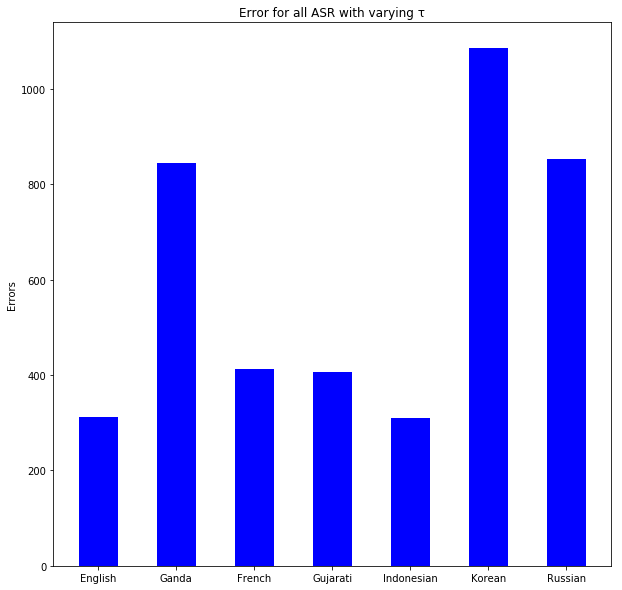

In [47]:
# All Errors plots
width = 0.5
# spacing = 0.2
colors = ['r', 'g', 'b', 'y']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(LANGUAGES)
ind = np.arange(N * step_size, step = step_size) 
# print(ind + width*i)

rects = []

sum_arrs = []
error_data_nuggets_subset = copy.deepcopy(error_data_nuggets)
sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
sum_arrs.append(sum_arr)

# print(sum_arrs)
    
rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(LANGUAGES, sum_arr)




# ax.legend((rect for rect in rects), (tau_val for tau_val in tau_vals))
ax.set_xticks(ind + width *2)
ax.set_xticklabels( LANGUAGES)
ax.set_ylabel('Errors')
plt.title ("Error for all ASR with varying τ")
plt.show()


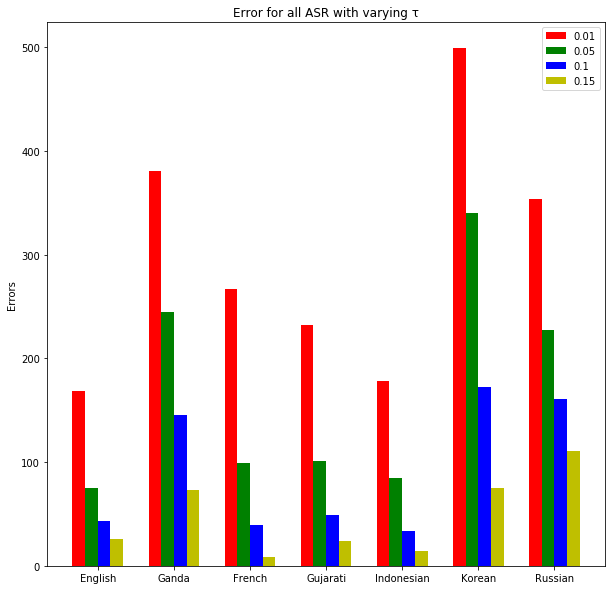

In [21]:
## Tau vary plots
width = 0.25
# spacing = 0.2
colors = ['r', 'g', 'b', 'y']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(LANGUAGES)
ind = np.arange(N * step_size, step = step_size) 
# print(ind + width*i)

rects = []

sum_arrs = []
for i, tau_val in enumerate(tau_vals):
#     print(i)
    error_data_nuggets_subset = get_tau_data_subset(error_data_nuggets, tau = tau_val)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(LANGUAGES, sum_arr)




ax.legend((rect for rect in rects), (tau_val for tau_val in tau_vals))
ax.set_xticks(ind + width * 1.5)
ax.set_xticklabels( LANGUAGES)
ax.set_ylabel('Errors')
plt.title ("Error for all ASR with varying τ")
plt.show()


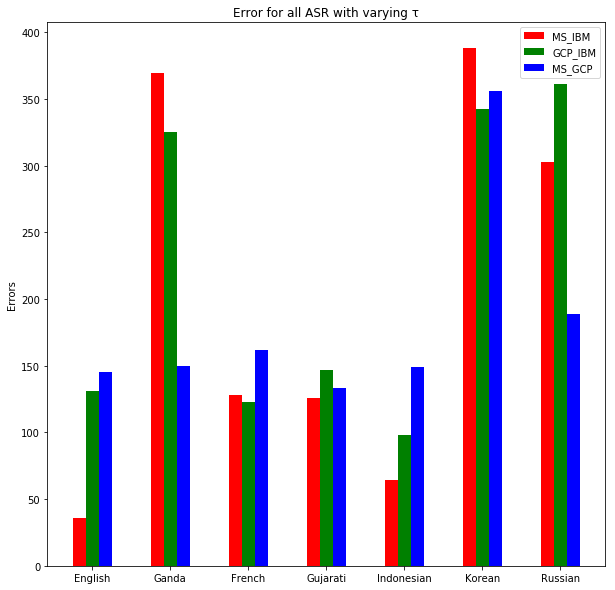

In [52]:
## ASR_TYPE vary plots
width = 0.25
# spacing = 0.2
colors = ['r', 'g', 'b', 'y']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(LANGUAGES)
ind = np.arange(N * step_size, step = step_size) 
# print(ind + width*i)

rects = []

sum_arrs = []
for i, asr_type in enumerate(ASR_TYPES):
    error_data_nuggets_subset = get_asr_type_data_subset(error_data_nuggets, asr_type = asr_type)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)

# print(sum_arrs)
    
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(LANGUAGES, sum_arr)




ax.legend((rect for rect in rects), (asr_type for asr_type in ASR_TYPES))
ax.set_xticks(ind + width * 1)
ax.set_xticklabels( LANGUAGES)
ax.set_ylabel('Errors')
plt.title ("Error for all ASR with varying τ")
plt.show()


[ 1.25  2.75  4.25  5.75  7.25  8.75 10.25]


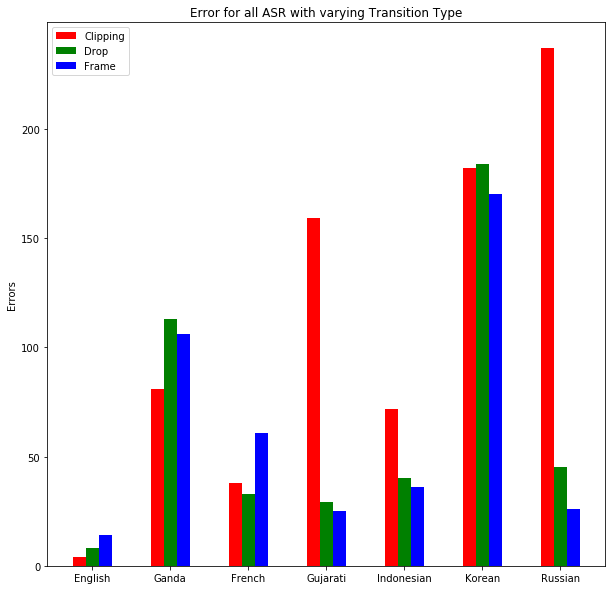

In [38]:
## Tr_Type vary plots where English does very well
width = 0.25
# spacing = 0.2
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'tab:orange']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5

TR_TYPES = ["Clipping", "Drop", "Frame"]


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(LANGUAGES)
ind = np.arange(N * step_size, step = step_size) 
print(ind + width*i)

rects = []

sum_arrs = []
for i, trans_type in enumerate(TR_TYPES):
    error_data_nuggets_subset = get_asr_tr_type_subset(error_data_nuggets, tr_type = trans_type)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)

# print(sum_arrs)
    
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(LANGUAGES, sum_arr)




ax.legend((rect for rect in rects), (trans_type for trans_type in TR_TYPES))
ax.set_xticks(ind + width )
ax.set_xticklabels(LANGUAGES)
ax.set_ylabel('Errors')
plt.title ("Error for all ASR with varying Transition Type")
plt.show()


[0.25 1.75 3.25 4.75 6.25 7.75 9.25]


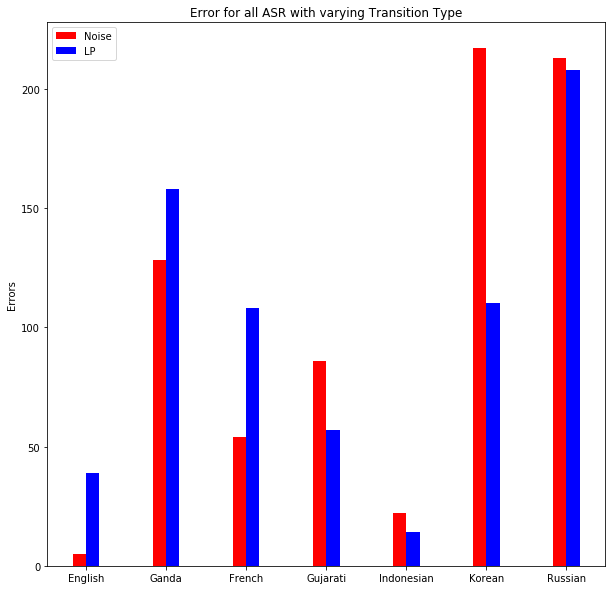

In [51]:
## Tr_Type vary plots where English does very well
width = 0.25
# spacing = 0.2
colors = ['r', 'b', 'g', 'y', 'c', 'm', 'k', 'tab:orange']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5

TR_TYPES = ["Noise", "LP"]


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(LANGUAGES)
ind = np.arange(N * step_size, step = step_size) 
print(ind + width*i)

rects = []

sum_arrs = []
for i, trans_type in enumerate(TR_TYPES):
    error_data_nuggets_subset = get_asr_tr_type_subset(error_data_nuggets, tr_type = trans_type)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)

# print(sum_arrs)
    
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(LANGUAGES, sum_arr)




ax.legend((rect for rect in rects), (trans_type for trans_type in TR_TYPES))
ax.set_xticks(ind + width * 0.5 )
ax.set_xticklabels(LANGUAGES)
ax.set_ylabel('Errors')
plt.title ("Error for all ASR with varying Transition Type")
plt.show()


[0.25 1.75 3.25 4.75 6.25 7.75 9.25]


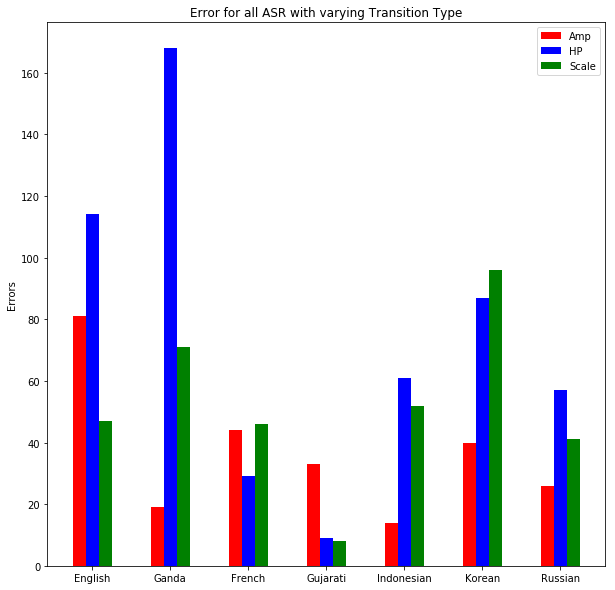

In [44]:
## Tr_Type vary plots where English does comparaby to others
width = 0.25
# spacing = 0.2
colors = ['r', 'b', 'g', 'y', 'c', 'm', 'k', 'tab:orange']
tau_vals = [0.01, 0.05, 0.1, 0.15]
step_size = 1.5

TR_TYPES = ["Amp", "HP", "Scale"]


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

N = len(LANGUAGES)
ind = np.arange(N * step_size, step = step_size) 
print(ind + width*i)

rects = []

sum_arrs = []
for i, trans_type in enumerate(TR_TYPES):
    error_data_nuggets_subset = get_asr_tr_type_subset(error_data_nuggets, tr_type = trans_type)
    sum_arr = (get_data_nugget_sums(error_data_nuggets_subset))
    sum_arrs.append(sum_arr)

# print(sum_arrs)
    
    rects.append(ax.bar(ind + width*i, sum_arr, width = width, color=colors[i]))
#     plt.bar(LANGUAGES, sum_arr)




ax.legend((rect for rect in rects), (trans_type for trans_type in TR_TYPES))
ax.set_xticks(ind + width )
ax.set_xticklabels(LANGUAGES)
ax.set_ylabel('Errors')
plt.title ("Error for all ASR with varying Transition Type")
plt.show()


In [ ]:
# print(len(error_data_nuggets))

# error_data_nuggets_subset = get_asr_tr_type_subset(get_asr_type_data_subset(error_data_nuggets, asr_type = "GCP_IBM"))
# # error_data_nuggets_subset = get_asr_tr_type_subset(error_data_nuggets)
# print(len(error_data_nuggets_subset))

# for data in error_data_nuggets_subset:
#     print(data.tau)
#     print(data.asr_type)
#     print(data.transformation_type)
#     print(data.error_row)
#     print("")
# print(get_data_nugget_sums(error_data_nuggets_subset))
# print()
    